In [5]:
%pylab inline
import IPython.core.debugger as ipdb
import argparse as argp
import nibabel as nib
import numpy as np
import os 
from nilearn import plotting

def dive(root):
    print(root)
    for f in os.listdir(root):
        path = rf'{root}/{f}'
        print(path)
        if f.endswith('.mgz'):
            nii_path = convert(root, f)
            clip_space(nii_path)
        elif os.path.isdir(path):
            dive(path)
            
def convert(root, f):
    os.system(rf'mri_convert {root}/{f} {root}/image.nii')
    return rf'mri_convert {root}/{f} {root}/image.nii'

# remove the surrounding zero-intensity space from the brain
def clip_boundary(path):
    img = nib.load(path)
    
    slice_0 = epi_img_data[26, :, :]
    axes[0].imshow(slice.T, cmap="gray", origin="lower")
    

Populating the interactive namespace from numpy and matplotlib


/home/yakuza/miniconda3/envs/pytorch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plotting']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
def clean_space(path):
    img = nib.load(path)
    np_img = np.array(img.get_fdata())
    plotting.plot_img(img, title="X_Real")
    plotting.show()
    
    # clean X 
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((y_len, z_len)) 
    del_inds = []
    for i in range(x_len):
        if np.sum(np_img[i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np_img, del_inds, 0)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(5)], zero_mask, 0)
    np_img = np.insert(np_img, [len(np_img) for i in range(5)], zero_mask, 0)

    # clean Y
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((x_len, z_len)) 
    del_inds = []
    for i in range(y_len):
        if np.sum(np_img[:, i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np.swapaxes(np_img, 0, 1), del_inds, 0)
    np_img = np.swapaxes(np_img, 0, 1)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(5)], np.zeros(z_len), 1)
    np_img = np.insert(np_img, [len(np_img[0]) for i in range(5)], np.zeros(z_len), 1)

    # clean Z
    x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
    zero_mask = np.zeros((x_len, y_len)) 
    del_inds = []
    for i in range(z_len):
        if np.sum(np_img[:, :, i] != zero_mask) == 0:
            del_inds.append(i)
    np_img = np.delete(np.swapaxes(np_img, 0, 2), del_inds, 0)
    np_img = np.swapaxes(np_img, 0, 2)
    # add paddings
    np_img = np.insert(np_img, [0 for i in range(5)], 0, 2)
    np_img = np.insert(np_img, [len(np_img[0][0]) for i in range(5)], 0, 2)

    # write to disk
    feat = nib.Nifti1Image(np_img, img.affine)
    nib.save(feat, '../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/mri/test.nii')
    
    # show image
#     feat = nib.load('../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/mri/test.nii')
#     plotting.plot_img(feat, title="X_Real")
#     plotting.show()
    

In [7]:
if __name__ == '__main__':
    parser = argp.ArgumentParser(description='convert .mgz files to .nii')
    parser.add_argument('path', type=str, nargs=1)
    args = parser.parse_args()
    dive(args.path[0])
    

usage: ipykernel_launcher.py [-h] path
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

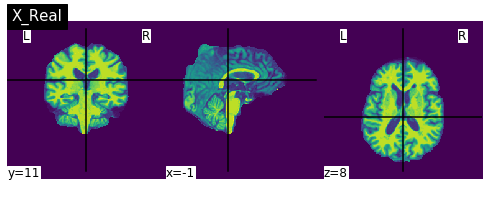

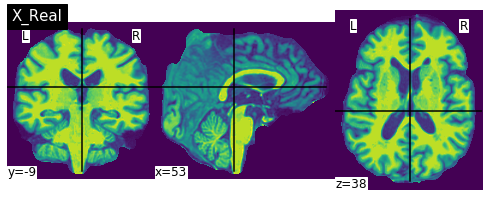

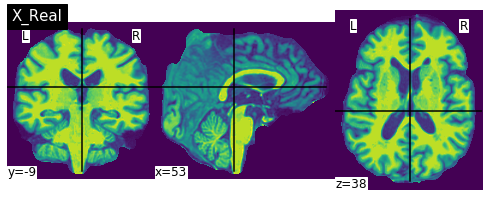

In [10]:
clean_space('../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/mri/image.nii')

In [ ]:
test = np.array([[1, 1], [2, 2], [3, 3]])

In [ ]:
np.insert(test, [1, 1, 1], [4, 4], 0)